## **1. imports**

In [1]:
## data
import pandas as pd
import numpy as np

## model
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
import sklearn.linear_model

from skopt import BayesSearchCV

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from pygam import LinearGAM, s, f

## visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

## utilities
import os
import pickle
import warnings

## 한글 폰트 표시
plt.rcParams['font.family'] ='NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

## 렌더링 설정
pio.templates.default = 'plotly_white'
pio.renderers.default = "vscode"

## warnings 처리
warnings.filterwarnings("ignore", category=UserWarning)

## **2. Data**

### **A. 데이터 불러오기**

In [2]:
housing_price = pd.read_csv("kc_house_data.csv")

## 시각화를 위한 전처리
df_preprocessed = housing_price.drop(["id", "date", "price"], axis = 1)\
.assign(date = pd.to_datetime(housing_price.date)).assign(price = housing_price.price)

## scores recoding
scoring_dict = dict()

### **B. 자료 분할**

In [3]:
def month_days_split(df_train : pd.DataFrame, df_test : pd.DataFrame) :
    test_month = df_test.date.dt.month.astype(str)
    test_days = df_test.date.map(lambda x : x - df_preprocessed.date.min()).dt.days
    train_month = df_train.date.dt.month.astype(str)
    train_days = df_train.date.map(lambda x : x - df_preprocessed.date.min()).dt.days
    
    return [train_month, train_days], [test_month, test_days]

df_train, df_test = train_test_split(df_preprocessed, test_size = 0.3, shuffle = True, random_state = 14107)
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

train_date, test_date = month_days_split(df_train, df_test)

## **3. Visualization & EDA**

### **A. 예측변수 주택 판매 가격의 분포**

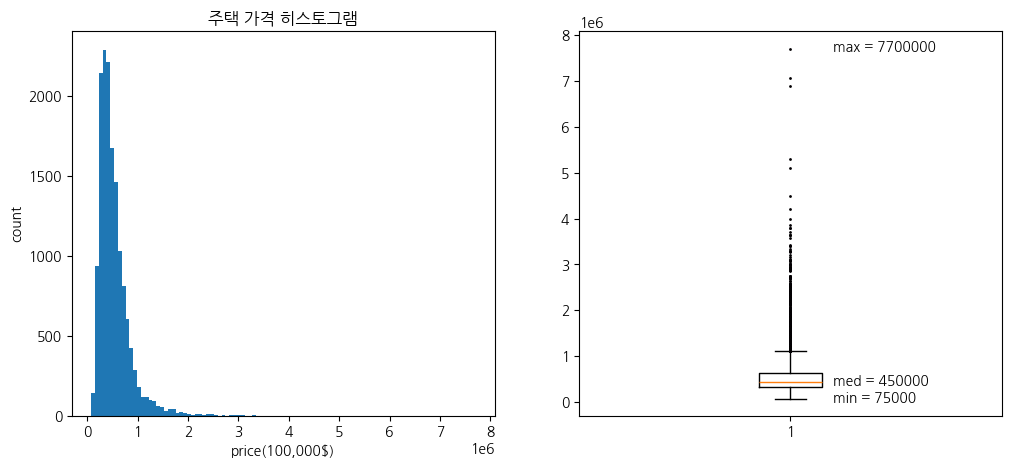

In [4]:
fig, axs = plt.subplots(1, 2, figsize = (12,5))

axs[0].hist(df_train.price, bins = 100)
axs[0].set_title("주택 가격 히스토그램")
axs[0].set_xlabel("price(100,000$)")
axs[0].set_ylabel("count")
axs[1].boxplot(df_train.price, flierprops={'marker': 'o', 'markersize': 1, 'markerfacecolor': 'fuchsia'})
axs[1].text(1.1, 0, f"min = {df_train.price.min():.0f}", fontsize=10)
axs[1].text(1.1, 375000, f"med = {df_train.price.median():.0f}", fontsize=10)
axs[1].text(1.1, 7650000, f"max = {df_train.price.max():.0f}", fontsize=10)
plt.show()

### **B. 각 설명변수들과 예측변수 간 관계 파악**

`-` 개별 설명변수(구매일자 제외)와 예측변수 간 산점도

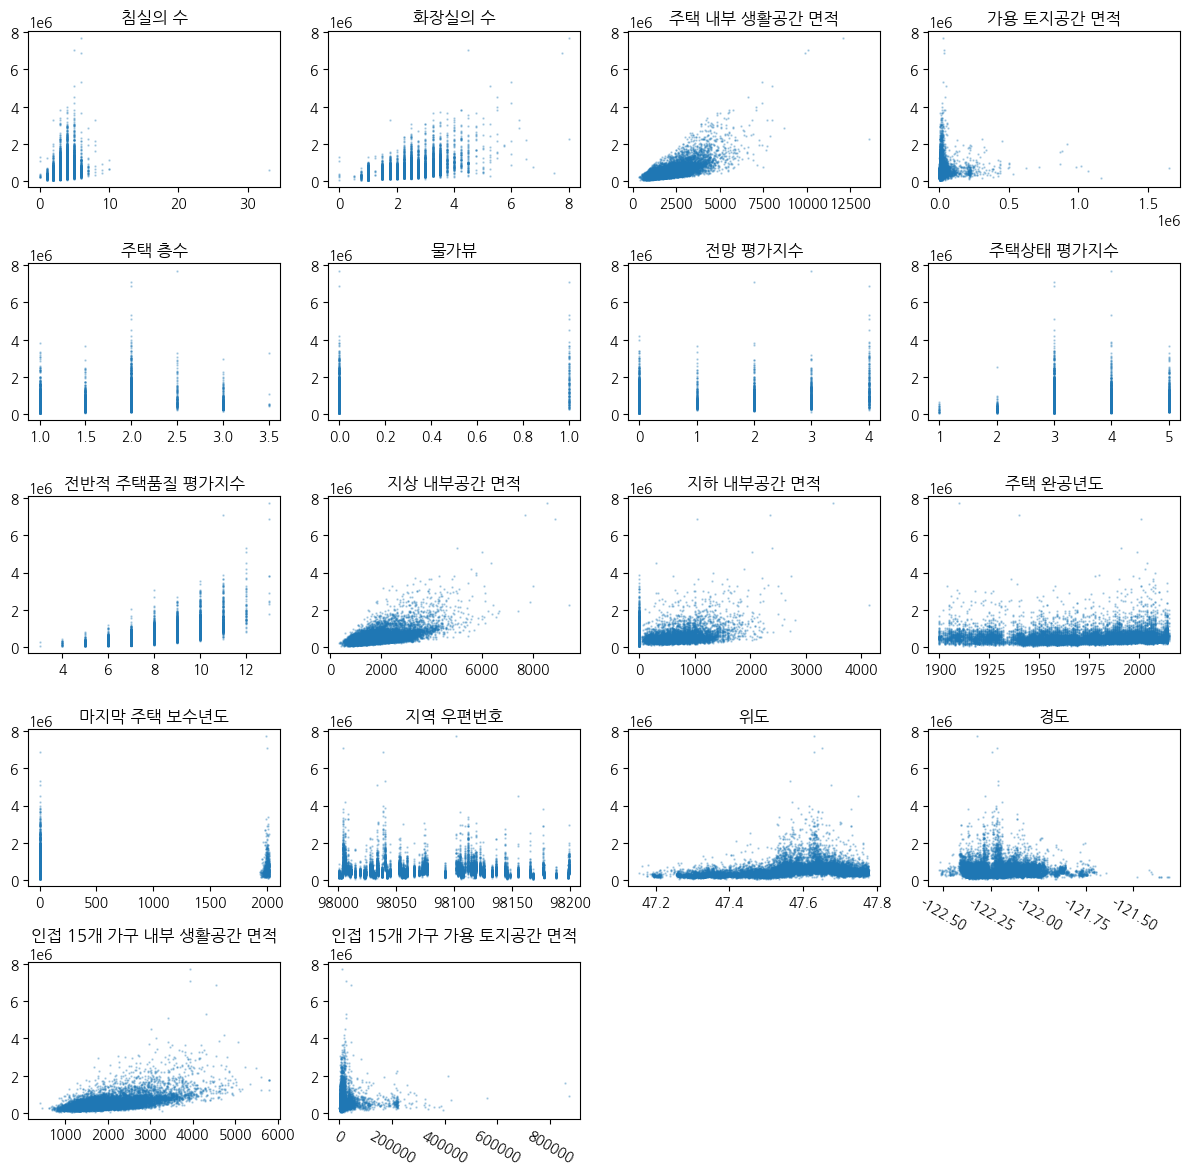

In [6]:
## 열 설명 딕셔너리 작성
description_list = ["ID", "주택 거래일", "주택 판매가격", "침실의 수", "화장실의 수", "주택 내부 생활공간 면적",
                    "가용 토지공간 면적", "주택 층수", "물가뷰", "전망 평가지수", "주택상태 평가지수", "전반적 주택품질 평가지수",
                    "지상 내부공간 면적", "지하 내부공간 면적", "주택 완공년도", "마지막 주택 보수년도", "지역 우편번호",
                    "위도", "경도", "인접 15개 가구 내부 생활공간 면적", "인접 15개 가구 가용 토지공간 면적"]

data_dict = {v:d for v, d in zip(housing_price.columns, description_list)}
col_list = df_train.columns

## 산점도
fig, axs = plt.subplots(5, 4, figsize = (12,12))

for i in range(5) :
    for j in range(4) :
        if (i*4+j >= 18) :
            break
            
        axs[i, j].scatter(df_train.iloc[:, i*4+j], df_train.price, s = 0.5, alpha = 0.3)
        axs[i, j].set_title(data_dict[col_list[i*4+j]])

        if col_list[i*4+j] in ("long", "sqft_lot15") :
            axs[i, j].tick_params(axis='x', rotation=-30)

axs[4, 2].remove()
axs[4, 3].remove()
fig.tight_layout()
plt.show()

`-` 구매 일자 관련 시각화

In [7]:
## 월별 주택 판매가격 상자 그림
fig = go.Figure()
fig.add_trace(
    go.Box(
        x = train_date[0], y = df_train.price,
        notched=True
    )
)

fig.update_layout(title=dict(text="월별 주택 판매 가격에 대한 상자 그림", font=dict(size=30), x = 0.5, y = 0.95), height = 800)
fig.update_xaxes(dtick=1)
fig.show()

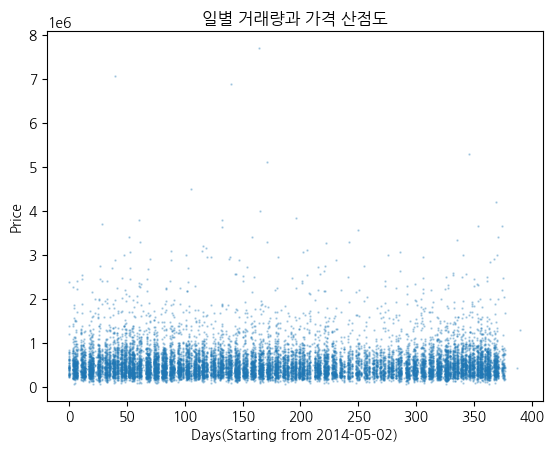

In [9]:
## 주택 판매일과 주택 가격 간 산점도
plt.scatter(train_date[1], df_train.price, s = 0.5, alpha = 0.3)
plt.title("일별 거래량과 가격 산점도")
plt.xlabel("Days(Starting from 2014-05-02)")
plt.ylabel("Price")
plt.show()

### **C. 변수 간 선형 상관계수 히트맵(절대값 스케일)**

In [10]:
## generating tidy data
tidy_data = df_train.corr().stack().reset_index().rename({"level_0" : "var1", "level_1" : "var2", 0 : "correlation"}, axis = 1)\
.assign(abs_corr = lambda _df : _df.correlation.map(lambda x : abs(x)))
tidy_data = pd.concat([tidy_data.loc[tidy_data.var1 == 'bedrooms'][::-1], tidy_data.iloc[20:, :]], axis = 0)

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x = tidy_data.var1, y = tidy_data.var2, z = tidy_data.abs_corr,
        text = tidy_data.correlation, texttemplate="%{text:.2f}"
    )
)

fig.update_layout(title=dict(text="20개 변수 간 상관계수", font=dict(size=30), x = 0.5, y = 0.95), height = 800)
fig.show()

In [ ]:
## 상관계수의 절대값이 0.7 이상인 변수들
tidy_data.loc[(tidy_data.abs_corr > 0.7) & (tidy_data.var1 != tidy_data.var2)]\
.assign(combine_set = lambda _df : (_df.var1 + " " + _df.var2).str.split().map(lambda x : set(x)))\
.loc[lambda _df : _df.combine_set.drop_duplicates().index]

,var1,var2,correlation,abs_corr,combine_set
22,bathrooms,sqft_living,0.756053,0.756053,"{bathrooms, sqft_living}"
48,sqft_living,grade,0.764164,0.764164,"{sqft_living, grade}"
49,sqft_living,sqft_above,0.878998,0.878998,"{sqft_living, sqft_above}"
56,sqft_living,sqft_living15,0.753548,0.753548,"{sqft_living, sqft_living15}"
59,sqft_living,price,0.701565,0.701565,"{sqft_living, price}"
77,sqft_lot,sqft_lot15,0.710831,0.710831,"{sqft_lot15, sqft_lot}"
169,grade,sqft_above,0.755626,0.755626,"{grade, sqft_above}"
176,grade,sqft_living15,0.713762,0.713762,"{sqft_living15, grade}"
196,sqft_above,sqft_living15,0.728683,0.728683,"{sqft_living15, sqft_above}"


## **4. 다중선형회귀모형 적용**

In [24]:
#-----일별 분석-----
## 1. data : 일별 분석
X = df_train.drop(["date", "price"], axis = 1).assign(days = train_date[1])
y = df_train.price

XX = df_test.drop(["date", "price"], axis = 1).assign(days = test_date[1])
yy = df_test.price

## 2. predictor
predictr = sklearn.linear_model.LinearRegression()
predictr.fit(X, y)

## 3. prediction
yyhat = predictr.predict(XX)

## 4. evaluation
scoring_dict["Linear Regression with days"] = np.mean((yy - yyhat)**2)**0.5
print(f"RMSE = {np.mean((yy - yyhat)**2)**0.5:.4f}")

#-----월별 분석-----
## 1. data
X = pd.get_dummies(df_train.drop(["date", "price"], axis = 1).assign(month = train_date[0]), drop_first = True, dtype = int)
y = df_train.price

XX = pd.get_dummies(df_test.drop(["date", "price"], axis = 1).assign(month = test_date[0]), drop_first = True, dtype = int)
yy = df_test.price


## 2. predictor
predictr = sklearn.linear_model.LinearRegression()
predictr.fit(X, y)

## 3. prediction
yyhat = predictr.predict(XX)

## 4. evaluation
scoring_dict["Linear Regression with month"] = np.mean((yy - yyhat)**2)**0.5
print(f"RMSE = {np.mean((yy - yyhat)**2)**0.5:.4f}")

## ANOVA table
model = sm.OLS(y, pd.concat([pd.DataFrame({'intercept' : np.ones(X.shape[0])}), X], axis = 1))
results = model.fit()

print(results.summary().tables[1])

RMSE = 196509.2480
RMSE = 196439.3155
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      7.575e+06   3.54e+06      2.141      0.032    6.39e+05    1.45e+07
bedrooms       -3.51e+04   2234.349    -15.710      0.000   -3.95e+04   -3.07e+04
bathrooms      4.274e+04   3889.469     10.988      0.000    3.51e+04    5.04e+04
sqft_living     110.5253      2.729     40.501      0.000     105.176     115.874
sqft_lot          0.1265      0.056      2.274      0.023       0.017       0.235
floors         9049.4422   4289.175      2.110      0.035     642.141    1.75e+04
waterfront     6.287e+05   2.01e+04     31.253      0.000    5.89e+05    6.68e+05
view           4.807e+04   2570.042     18.705      0.000     4.3e+04    5.31e+04
condition      2.899e+04   2819.808     10.282      0.000    2.35e+04    3.45e+04
grade          9.665e+04   2593.196     37.269      0.000   

## **5. 벌점 함수 모형 적용 : RIDGE**

`-` 변수 스케일링 & 하이퍼 파라미터 CV

In [26]:
## fitting scaler with train set
numeric_features = df_train.loc[:, :"sqft_lot15"]
scalr = StandardScaler()
y_scalr = PowerTransformer() ## 선형 모형이므로 반응변수에 파워 변환을 해봄
standarized_features = scalr.fit_transform(numeric_features)

## train data
X_trans = np.concatenate([standarized_features, np.asarray(pd.get_dummies(train_date[0], drop_first = True, dtype = int))], axis = 1) ## features
y_trans = np.asarray(y_scalr.fit_transform(pd.DataFrame(df_train.price))).reshape(-1) ## scaled target

## test data
XX_trans = np.concatenate([scalr.transform(df_test.loc[:, :"sqft_lot15"]), np.asarray(pd.get_dummies(test_date[0], drop_first = True, dtype = int))], axis = 1)
yy_trans = np.asarray(y_scalr.transform(pd.DataFrame(df_test.price))).reshape(-1)

## fitting and cross validation(10-fold)
lambdas = 10**np.linspace(2, -4, 100) ## setting grid for plotting
kfold = KFold(10, random_state = 14107, shuffle = True)
ridgeCV = sklearn.linear_model.ElasticNetCV(alphas = lambdas, l1_ratio = 0, cv = kfold)
ridgeCV.fit(X_trans, y)

## fitting and cross validation(10-fold)
lambdas = 10**np.linspace(3, -5, 100) ## setting grid for plotting
kfold = KFold(10, random_state = 14107, shuffle = True)
ridgeCV_trans = sklearn.linear_model.ElasticNetCV(alphas = lambdas, l1_ratio = 0, cv = kfold)
ridgeCV_trans.fit(X_trans, y_trans)

ElasticNetCV(alphas=array([1.00000000e+03, 8.30217568e+02, 6.89261210e+02, 5.72236766e+02,
       4.75081016e+02, 3.94420606e+02, 3.27454916e+02, 2.71858824e+02,
       2.25701972e+02, 1.87381742e+02, 1.55567614e+02, 1.29154967e+02,
       1.07226722e+02, 8.90215085e+01, 7.39072203e+01, 6.13590727e+01,
       5.09413801e+01, 4.22924287e+01, 3.51119173e+01, 2.91505306e+01,
       2.42012826e+01, 2.009233...
       3.43046929e-04, 2.84803587e-04, 2.36448941e-04, 1.96304065e-04,
       1.62975083e-04, 1.35304777e-04, 1.12332403e-04, 9.32603347e-05,
       7.74263683e-05, 6.42807312e-05, 5.33669923e-05, 4.43062146e-05,
       3.67837977e-05, 3.05385551e-05, 2.53536449e-05, 2.10490414e-05,
       1.74752840e-05, 1.45082878e-05, 1.20450354e-05, 1.00000000e-05]),
             cv=KFold(n_splits=10, random_state=14107, shuffle=True),
             l1_ratio=0)

`-` 시각화 및 $\lambda$ 탐색

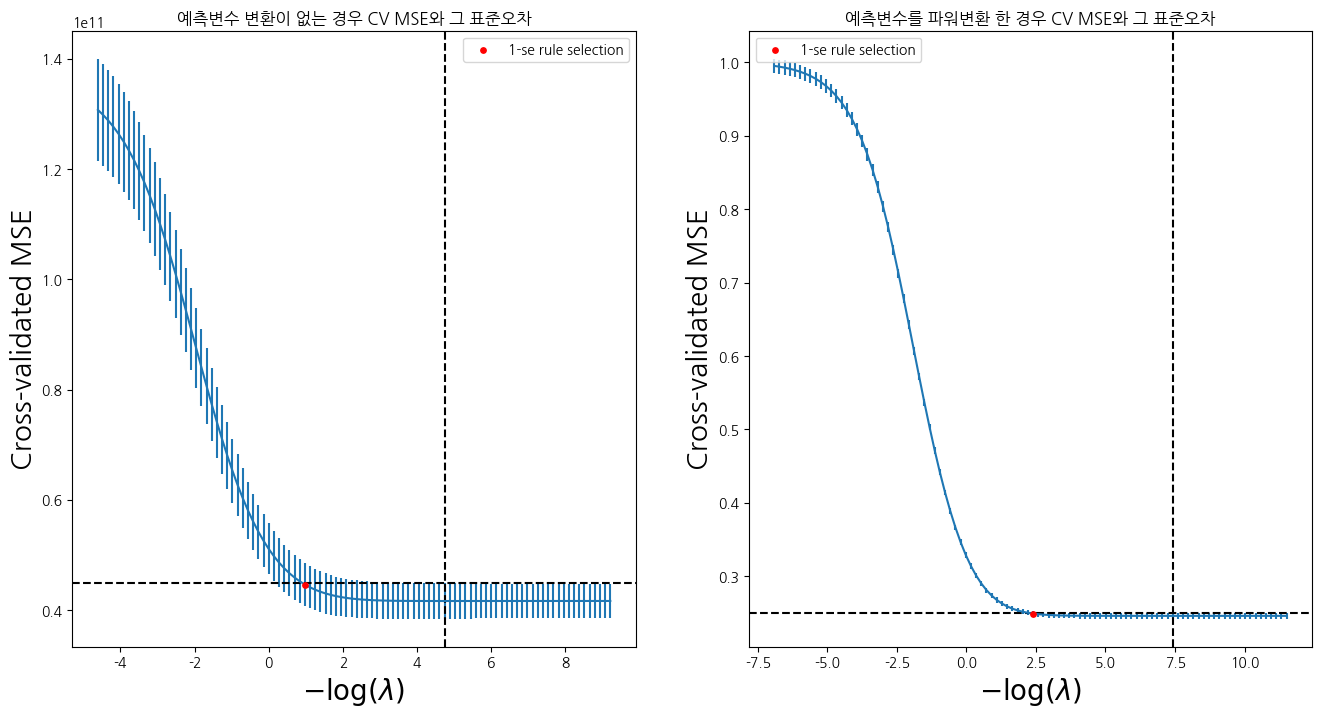

선택된 lambda(raw) =  0.37649,  0.00870
선택된 lambda(powertransform) =  0.09112,  0.00060


In [27]:
## optimized value
mse_list = ridgeCV.mse_path_.mean(1)
indx = np.where(mse_list == np.min(mse_list))
min_mse = mse_list[indx]
min_std = ridgeCV.mse_path_.std(1)[indx]
simple_indx = np.min(np.where(mse_list <= min_mse + min_std / np.sqrt(10)))

## using powertransformer
mse_list_trans = ridgeCV_trans.mse_path_.mean(1)
indx_trans = np.where(mse_list_trans == np.min(mse_list_trans))
min_mse_trans = mse_list_trans[indx_trans]
min_std_trans = ridgeCV_trans.mse_path_.std(1)[indx]
simple_indx_trans = np.min(np.where(mse_list_trans <= min_mse_trans + min_std_trans / np.sqrt(10)))

## plotting
lassoCV_fig, axs = plt.subplots(1, 2, figsize=(16,8))
axs[0].errorbar(-np.log(ridgeCV.alphas_), ridgeCV.mse_path_.mean(1),
            yerr=ridgeCV.mse_path_.std(1) / np.sqrt(10))
axs[0].axvline(-np.log(ridgeCV.alpha_), c='k', ls='--')
axs[0].axhline(min_mse + min_std / np.sqrt(10), c = 'k', ls = '--')
axs[0].set_xlabel('$-\log(\lambda)$', fontsize=20)
axs[0].set_ylabel('Cross-validated MSE', fontsize=20)
axs[0].scatter(-np.log(ridgeCV.alphas_[simple_indx]), mse_list[simple_indx],
           color = "red", s = 15, label = "1-se rule selection", zorder = 5)
axs[0].set_title("예측변수 변환이 없는 경우 CV MSE와 그 표준오차")
axs[0].legend()

axs[1].errorbar(-np.log(ridgeCV_trans.alphas_), ridgeCV_trans.mse_path_.mean(1),
            yerr=ridgeCV_trans.mse_path_.std(1) / np.sqrt(10))
axs[1].axvline(-np.log(ridgeCV_trans.alpha_), c='k', ls='--')
axs[1].axhline(min_mse_trans + min_std_trans / np.sqrt(10), c = 'k', ls = '--')
axs[1].set_xlabel('$-\log(\lambda)$', fontsize=20)
axs[1].set_ylabel('Cross-validated MSE', fontsize=20)
axs[1].scatter(-np.log(ridgeCV_trans.alphas_[simple_indx_trans]), mse_list_trans[simple_indx_trans],
           color = "red", s = 15, label = "1-se rule selection", zorder = 5)
axs[1].set_title("예측변수를 파워변환 한 경우 CV MSE와 그 표준오차")
axs[1].legend()

plt.show()

## showing parameter
optim_ridge = ridgeCV.alpha_
optim_ridge_1se = ridgeCV.alphas_[simple_indx]
optim_ridge_trans = ridgeCV_trans.alpha_
optim_ridge_1se_trans = ridgeCV_trans.alphas_[simple_indx_trans]
print(f'선택된 lambda(raw) = {optim_ridge_1se : .5f}, {optim_ridge : .5f}')
print(f"선택된 lambda(powertransform) = {optim_ridge_1se_trans : .5f}, {optim_ridge_trans : .5f}")

`-` 선택된 $\lambda$에 따른 모형 비교

In [28]:
## CV optimized predictor : raw price
predictr_optim = sklearn.linear_model.ElasticNet(alpha = optim_ridge, l1_ratio = 0)
predictr_optim.fit(X_trans, y)
yyhat = predictr_optim.predict(XX_trans)
scoring_dict["Ridge Regression"] = np.mean((yy - yyhat)**2)**0.5
print(f"raw price RMSE = {np.mean((yy - yyhat)**2)**0.5:.4f}")

## CV optimized predictor : transformed price
predictr_optim_trans = sklearn.linear_model.ElasticNet(alpha = optim_ridge_trans, l1_ratio = 0)
predictr_optim_trans.fit(X_trans, y_trans)
yyhat = y_scalr.inverse_transform(predictr_optim.predict(XX_trans).reshape(-1,1)).reshape(-1)
scoring_dict["Ridge Regression with transformed price"] = np.mean((yy - yyhat)**2)**0.5
print(f"transformed price RMSE = {np.mean((yy - yyhat)**2)**0.5:.4f}")

## 1-se-rule predictor : raw price
predictr_1se = sklearn.linear_model.ElasticNet(alpha = optim_ridge_1se, l1_ratio = 0)
predictr_1se.fit(X_trans, y)
yyhat = predictr_1se.predict(XX_trans)
scoring_dict["Ridge Regression with 1-se rule"] = np.mean((yy - yyhat)**2)**0.5
print(f"raw price 1se rule RMSE = {np.mean((yy - yyhat)**2)**0.5:.4f}")

## 1-se-rule predictor : transformed price
predictr_1se = sklearn.linear_model.ElasticNet(alpha = optim_ridge_1se_trans, l1_ratio = 0)
predictr_1se.fit(X_trans, y_trans)
yyhat = y_scalr.inverse_transform(predictr_1se.predict(XX_trans).reshape(-1,1)).reshape(-1)
scoring_dict["Ridge Regression with transformed price & 1-se rule"] = np.mean((yy - yyhat)**2)**0.5
print(f"transformed price 1se rule RMSE = {np.mean((yy - yyhat)**2)**0.5:.4f}")

raw price RMSE = 196355.4463
transformed price RMSE = 218913.8812
raw price 1se rule RMSE = 203056.3837
transformed price 1se rule RMSE = 289343.2780


## **6. 비선형 모형 적용**

`-` 시각화 및 $\lambda$ 탐색

In [111]:
## lambda grid
lams = 10**np.linspace(-1, 4, 50)
kfold = KFold(5, random_state = 14107, shuffle = True)

## 초기화
mean_scores = []
std_scores = []

## CV
for i, lam in enumerate(lams):
    scores = []
    
    for train_idx, valid_idx in kfold.split(X):
        X_train, X_valid = X.to_numpy()[train_idx], X.to_numpy()[valid_idx]
        y_train, y_valid = y.to_numpy()[train_idx], y.to_numpy()[valid_idx]

        gam = LinearGAM(lam=lam).fit(X_train, y_train)
        yyhat = gam.predict(X_valid)
        rmse = np.mean((y_valid - yyhat)**2)**0.5
        scores.append(rmse)

    mean_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

    print(f"{i} cycle rooped")

0 cycle rooped
1 cycle rooped
2 cycle rooped
3 cycle rooped
4 cycle rooped
5 cycle rooped
6 cycle rooped
7 cycle rooped
8 cycle rooped
9 cycle rooped
10 cycle rooped
11 cycle rooped
12 cycle rooped
13 cycle rooped
14 cycle rooped
15 cycle rooped
16 cycle rooped
17 cycle rooped
18 cycle rooped
19 cycle rooped
20 cycle rooped
21 cycle rooped
22 cycle rooped
23 cycle rooped
24 cycle rooped
25 cycle rooped
26 cycle rooped
27 cycle rooped
28 cycle rooped
29 cycle rooped
30 cycle rooped
31 cycle rooped
32 cycle rooped
33 cycle rooped
34 cycle rooped
35 cycle rooped
36 cycle rooped
37 cycle rooped
38 cycle rooped
39 cycle rooped
40 cycle rooped
41 cycle rooped
42 cycle rooped
43 cycle rooped
44 cycle rooped
45 cycle rooped
46 cycle rooped
47 cycle rooped
48 cycle rooped
49 cycle rooped


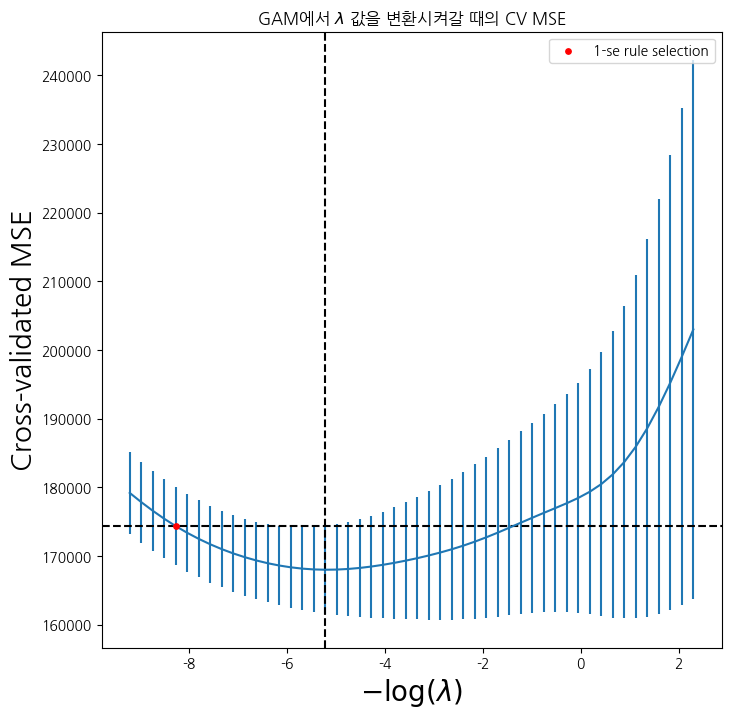

Optimal : 184.2070
1-se rule : 3906.9399


In [173]:
## optimized value
indx = np.where(mean_scores == np.min(mean_scores))[0][0]
min_mse = mean_scores[indx]
min_std = std_scores[indx]
simple_indx = np.max(np.where(mean_scores <= min_mse + min_std / np.sqrt(5)))

## plotting
fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(-np.log(lams), mean_scores, yerr = std_scores/np.sqrt(5))
ax.axvline(-np.log(lams[indx]), c='k', ls='--')
ax.axhline(min_mse + min_std / np.sqrt(5), c = 'k', ls = '--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.scatter(-np.log(lams[simple_indx]), mean_scores[simple_indx],
           color = "red", s = 15, label = "1-se rule selection", zorder = 5)
ax.set_title(f"GAM에서 $\lambda$ 값을 변환시켜갈 때의 CV MSE")

plt.legend()
plt.show()

## optimal lambda
optim_lambda = lams[indx]
optim_1se_lambda = lams[simple_indx]
print(f"Optimal : {optim_lambda:.4f}")
print(f"1-se rule : {optim_1se_lambda:.4f}")

`-` test RMSE 산출

In [178]:
## test RMSE 산출
gam = LinearGAM(lam = optim_lambda)
gam.fit(X, y)
scoring_dict["GAM"] = np.mean((yy - gam.predict(XX.to_numpy()))**2)**0.5
print(f"RMSE = {np.mean((yy - gam.predict(XX.to_numpy()))**2)**0.5:.4f}")

gam = LinearGAM(lam = optim_1se_lambda)
gam.fit(X, y)
scoring_dict["GAM with 1-se rule"] = np.mean((yy - gam.predict(XX.to_numpy()))**2)**0.5
print(f"RMSE = {np.mean((yy - gam.predict(XX.to_numpy()))**2)**0.5:.4f}")

RMSE = 156864.5731
RMSE = 165829.6970


## **7. 나무 모형**

In [181]:
with open("scoring_dict.pkl", "wb") as f :
    pickle.dump(scoring_dict, f)

# with open("scoring_dict.pkl", "rb") as f :
#     scoring_dict = pickle.load(f)

In [114]:
with open("GAM mse.pkl", "wb") as f :
    pickle.dump(GAM_mse, f)

# with open("GAM mse.pkl", "rb") as f :
#     GAM_mse = pickle.load(f)